In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

## Read in data

In [2]:
# get all file paths
files = glob('data/genres_original/*/*.wav')
print(files[:3])
print('File count: ', len(files))

['data/genres_original/reggae/reggae.00056.wav', 'data/genres_original/reggae/reggae.00014.wav', 'data/genres_original/reggae/reggae.00017.wav']
File count:  1000


In [3]:
ipd.Audio(files[0])

In [4]:
y, sr = librosa.load(files[0])
print(y.shape)
print(sr)

(661504,)
22050


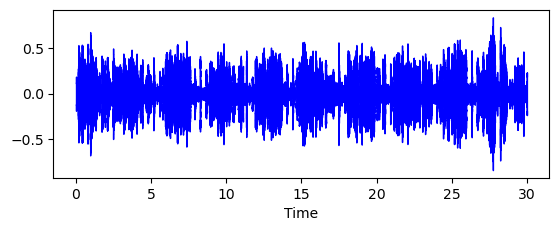

In [5]:
plt.subplot(2,1,1)
librosa.display.waveshow(y, sr=sr, color='b')
plt.show()